<a href="https://colab.research.google.com/github/PMatthaei/pymarl-results/blob/master/visualize_pymarl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Visualization of PyMARL experiments

This notebook visualizes results of experiments conducted on PyMARL.

Main repository: https://github.com/oxwhirl/pymarl

Fork: https://github.com/PMatthaei/pymarl

Results repository: https://github.com/PMatthaei/pymarl-results


In [25]:
#@title Choose your experiments

#@markdown Choose algorithms
qmix = False #@param {type:"boolean"}
vdn = True #@param {type:"boolean"}
iql = False #@param {type:"boolean"}
coma = False #@param {type:"boolean"}
qtran = False #@param {type:"boolean"}

#@markdown Choose environments
three_marines = True #@param {type:"boolean"}
eight_marines = False #@param {type:"boolean"}
twentyfive_marines = False #@param {type:"boolean"}
three_stalkers_five_zealots = False #@param {type:"boolean"}

In [26]:
# Fetch form data
envs = []
if three_marines: envs.append('3m')
if eight_marines: envs.append('8m')
if twentyfive_marines: envs.append('25m')
if three_stalkers_five_zealots: envs.append('3s5z')

algos = []
if qmix: algos.append('qmix')
if vdn: algos.append('vdn')
if iql: algos.append('iql')
if coma: algos.append('coma')
if qtran: algos.append('qtran')

print(algos)
print(envs)

['vdn']
['3m']


In [17]:
!git clone https://github.com/PMatthaei/pymarl-results.git

fatal: destination path 'pymarl-results' already exists and is not an empty directory.


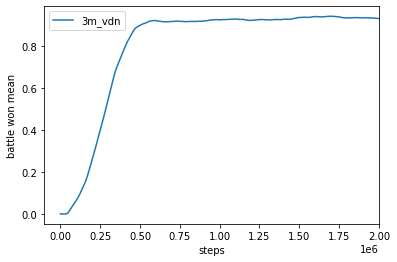

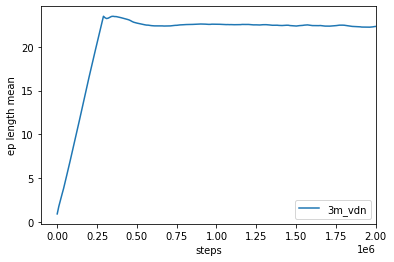

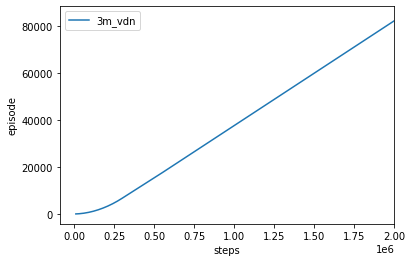

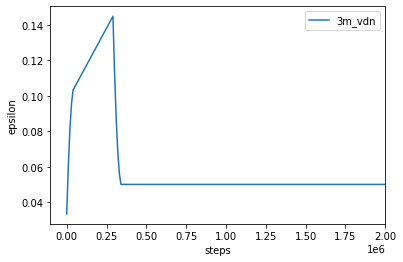

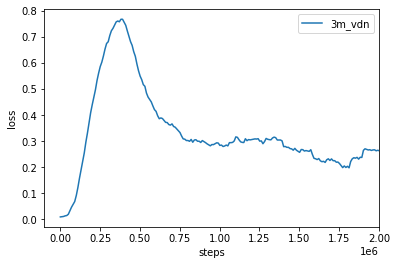

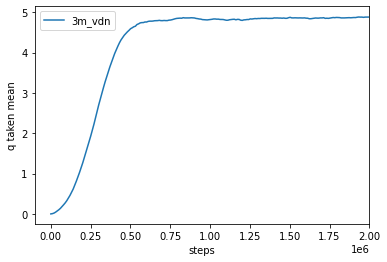

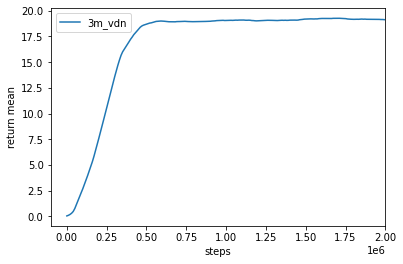

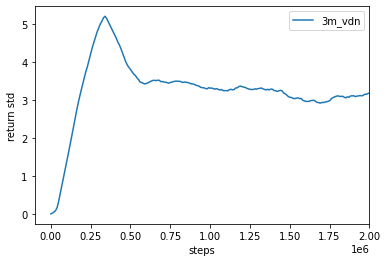

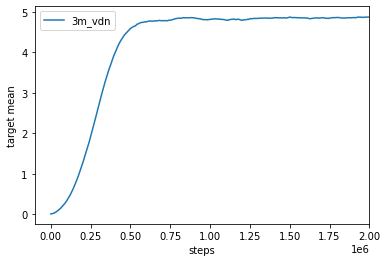

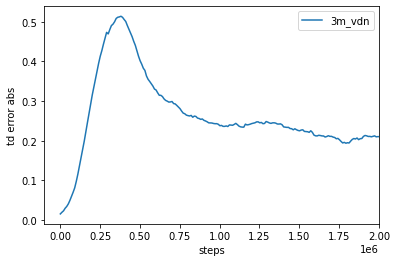

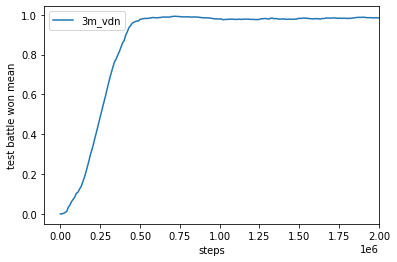

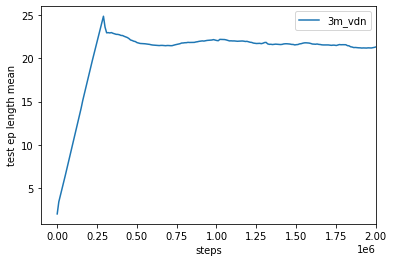

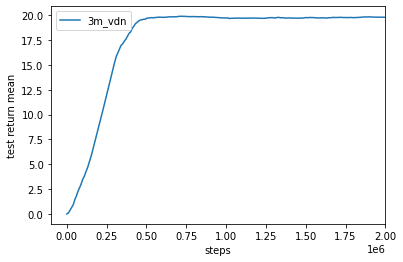

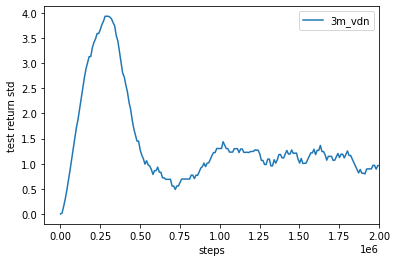

<Figure size 432x288 with 0 Axes>

In [27]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import re

from scipy.signal import lfilter
from pathlib import Path

plot_data = {}
metrics = []

def extract_plot_data():
  for path in Path('/content/pymarl-results').rglob('*info*.json'):
    label = extract_label(path, algos+envs)

    if is_algo(path, algos) and is_env(path, envs):
      with open(path) as json_file:
          data = json.load(json_file)
          for metric in data:
            if '_T' not in metric:

              if metric not in metrics:
                metrics.append(metric)

              transposed_identifier = metric+'_T'
              xs = data[transposed_identifier]
              ys = data[metric]

              if metric in plot_data:
                plot_data[metric].append((xs, ys, label))
              else:
                plot_data[metric] = []
                plot_data[metric].append((xs, ys, label))

n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

def plot():
  for metric in metrics:
    if metric == 'grad_norm':
      continue
    for i, data in enumerate(plot_data[metric]):
      ys = list(map(lambda x: x['value'] if isinstance(x,dict) else x, data[1]))
      plt.plot(data[0], lfilter(b,a, ys), label=data[2])
      plt.xlabel('steps')
      metric_label = metric.replace('_', ' ')
      plt.xlim(right=2000000)
      plt.ylabel(metric_label)
    plt.legend(loc='best')
    plt.show()
    plt.savefig(metric+'.png')

def is_env(path, envs):
  if len(envs) == 0:
    return True

  return any(env in str(path) for env in envs)

def is_algo(path, algos):
  if len(algos) == 0:
    return True

  return any(algo in str(path) for algo in algos)

def extract_label(path, search):
  return re.search(".*(results/)(.*)(/source).*",str(path))[2]

# main 
extract_plot_data()
plot()